# Heritability Analysis

As an application of the variance component model, this note demonstrates the workflow for heritability analysis in genetics, using a sample data set `SNP_29C` with **212** individuals and **253,141** SNPs. 

`SNP_29C.bed`, `SNP_29C.bim`, and `SNP_29C.fam` is a set of Plink files in binary format. `SNP_29Ctraitdata.txt` contains 2 phenotypes of the 212 individuals, column 1 identifies the individuals family ID, column 2 individual ID, and columns 3 and 4 are traits 1 and 2 respectively.

The `SNP_29C` dataset:

Simulated with realistic linkage disequilibrium (LD) structure and constructed from phased sequence data from chromosome 19 on 85 individuals of northern and western European ancestry. After removing mono-allelic markers this set of in- dividuals, 253,141 SNPs remained. Almost half of the SNPs have minor allele frequencies (MAF) below 5%. The haplotype pairs attributed to the 85 CEPH members were reas- signed to the 85 founders of 27 pedigree structures selected from the Framingham Heart Study (FHS, http://www.framinghamheartstudy.org). The selected Framingham pedi- grees were chosen to reflect the kind of pedigrees commonly collected in family-based genetic studies. The 27 pedigrees encompass 212 people, range in size from 1 to 36 peo- ple and from 1 to 5 generations, and contain sibships of 1 to 5 children. The genotypes of non-founders were simulated, using Option 17, conditional on the haplotypes imposed on the founders. All genotypes were recorded as unordered for subsequent analyses.

In [1]:
;ls "SNP_29C*.*"

SNP_29C.bed
SNP_29C.bim
SNP_29C.fam
SNP_29Ctraitdata.csv


Machine information:

In [2]:
versioninfo()

Julia Version 0.6.0
Commit 903644385b (2017-06-19 13:05 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin13.4.0)
  CPU: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Prescott)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, broadwell)


## Read in binary SNP data

We will use the [`SnpArrays.jl`](https://github.com/OpenMendel/SnpArrays.jl) package to read in binary SNP data and compute the empirical kinship matrix. Issue 
```julia
Pkg.clone("https://github.com/OpenMendel/SnpArrays.jl.git")
```
within `Julia` to install the `SnpArrays` package.

In [3]:
using SnpArrays

In [4]:
# read in genotype data from Plink binary file (~50 secs on my laptop)
@time SNP_29C = SnpArray("SNP_29C")

  0.609499 seconds (220.93 k allocations: 24.445 MiB, 1.32% gc time)


212×253141 SnpArrays.SnpArray{2}:
 (true, true)  (true, true)   …  (true, true)    (false, false)
 (true, true)  (true, true)      (true, true)    (false, false)
 (true, true)  (true, true)      (true, true)    (false, false)
 (true, true)  (true, true)      (true, true)    (false, false)
 (true, true)  (true, true)      (true, true)    (false, false)
 (true, true)  (true, true)   …  (false, false)  (true, true)  
 (true, true)  (false, true)     (false, false)  (true, true)  
 (true, true)  (true, true)      (false, false)  (true, true)  
 (true, true)  (false, true)     (false, false)  (true, true)  
 (true, true)  (false, true)     (false, false)  (true, true)  
 (true, true)  (false, true)  …  (false, false)  (true, true)  
 (true, true)  (true, true)      (false, false)  (true, true)  
 (true, true)  (false, true)     (false, false)  (true, true)  
 ⋮                            ⋱                  ⋮             
 (true, true)  (true, true)   …  (true, true)    (false, false)
 (true

## Summary statistics of SNP data

In [5]:
people, snps = size(SNP_29C)

(212, 253141)

In [6]:
# summary statistics (~50 secs on my laptop)
@time maf, _, missings_by_snp, = summarize(SNP_29C);

  0.410520 seconds (19.62 k allocations: 4.798 MiB, 1.75% gc time)


In [7]:
# 5 number summary and average MAF (minor allele frequencies)
quantile(maf, [0.0 .25 .5 .75 1.0]), mean(maf)

([0.00235849 0.0117925 … 0.228774 0.5], 0.13381461170905357)


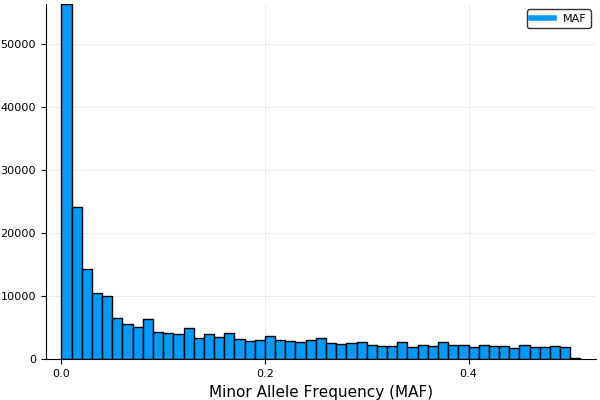

In [8]:
# Pkg.add("Plots")
# Pkg.add("PyPlot")
using Plots
pyplot()

histogram(maf, xlab = "Minor Allele Frequency (MAF)", label = "MAF")

In [9]:
# proportion of missing genotypes
sum(missings_by_snp) / length(SNP_29C)

0.0

In [10]:
# proportion of rare SNPs with maf < 0.05
countnz(maf .< 0.05) / length(maf)

0.4558724189285813

## Empirical Kinship Matrix

In this example we estimate the empirical kinships based on all 253,141 SNPs by Genetic Relationship Matrix.

Both the GRM and the MoM methods are fairly quick to calculate and provide good estimates for the kinship coefficients, given reasonably dense genome-wide data. When using the GRM method, very rare SNPs should not be used since they become overweighted. In general, one can think of the GRM method centering and scaling each genotype, while the MoM method uses the raw genotypes and then centers and scales the final result.

### Kinship via Genetic Relationship Matrix (GRM)

Under the GRM formulation, the estimate of the global kinship coefficient of individuals $i$ and $j$ is
$$ \widehat\Phi_{GRMij}^  = \frac{1}{2S} \sum_{k=1}^S \frac{(x_{ik} -2p_k)(x_{jk} - 2p_k)}{2 p_k (1-p_k)}$$,
where $k$ ranges over the selected $S$ SNPs, $p_k$ is the minor allele frequency of SNP $k$, and $x_{ik}$ is the number of minor alleles in individual $i$s genotype at SNP $k$.

It is often necessary to filter SNPs according to minor allele frequency and LD before calculating empirical kinship matrix. By default, the "grm" function exlcudes SNPs with minor allele frequency below 0.01. This can be changed by the keyword argument maf_threshold.

In this example we sample every fifth SNP, and exclude very rare SNPs (those with minor allele counts less than 3) since they become over weighted. Thus we set the maf_threshold = 3/ 212/ 2 =  0.0071.

In [11]:
@time ΦGRM = grm(SNP_29C[:, 1:5:end]; method = :GRM, maf_threshold = 0.0071)

  3.330394 seconds (20.67 M allocations: 484.741 MiB, 12.06% gc time)


212×212 Array{Float64,2}:
  0.503736      0.00450238    0.00560925   …   0.0202415    -0.00146227
  0.00450238    0.514562     -0.0192975       -0.0211945    -0.0190527 
  0.00560925   -0.0192975     0.492619        -0.0150127    -0.00337255
  0.248505     -0.00189301    0.262585         0.000939722  -0.00397642
  0.123444      0.26985       0.120157        -0.011537     -0.00704346
 -0.00873656   -0.000536772  -0.00104013   …   0.00274189    0.0117686 
 -0.0122605     0.00754381   -0.0084298       -0.0109589     0.00124671
 -0.0116844    -0.00831492   -0.0103027       -0.010893     -0.00465248
 -0.00847343    0.0016468    -0.0120892       -0.0212743    -0.00557705
 -0.00893916   -0.006521     -0.0138499       -0.00648165   -0.0127073 
 -0.0107549     0.00852362    0.00136741   …  -0.00404222    0.011256  
 -0.0112584     0.00481192   -0.00523649      -0.00627449    0.0065575 
 -0.0194832     0.000914529  -0.011264         0.00177211    0.0166304 
  ⋮                                   

### Kinship via Method of Moments (MoM)
Using the Method of Moments (MoM) formula, the estimate of the global kinship coefficient of individuals $i$ and $j$ is
$$ \widehat \Phi_{MoMij} = \frac{e_{ij} - \sum_{k=1}^S \left[p_k^2 + (1-p_k)^2 \right]}{S - \sum_{k=1}^S\left[p_k^2 + (1-p_k)^2\right]}, $$
where
$$ e_{ij}  =  \frac{1}{4} \sum_{k=1}^S \left[ x_{ik}x_{jk} + (2-x_{ik})(2-x_{jk}) \right] $$
is the observed fraction of alleles identical by state (IBS) between $i$ and $j$.

!!! note

    It is important to note that sometimes MoM formulation does not guarantee Positive Semi-Definiteness. Thus, for the rest of this example we will use the GRM formulation of the empirical Kinship coefficients. 

In [12]:
@time ΦMoM = grm(SNP_29C; method = :MoM)

  3.064000 seconds (85.80 M allocations: 1.604 GiB, 15.40% gc time)


212×212 Array{Float64,2}:
  0.506634     0.00429712   0.0260383    …  -0.00798769   0.00311508 
  0.00429712   0.507848    -0.0168319       -0.0591744   -0.0186789  
  0.0260383   -0.0168319    0.504523        -0.0498764    0.000360494
  0.243028    -0.0193543    0.268178        -0.0446627   -0.0185839  
  0.111198     0.241117     0.115525        -0.0691584   -0.0173807  
 -0.005898     0.004371     0.00643958   …  -0.0297183    0.0214895  
 -0.0165786    0.00881422  -0.00794547      -0.0459819   -0.00239409 
 -0.0109111   -0.00265794  -0.0128531       -0.0387419    0.00140534 
 -0.00260517   0.0155688    0.00462429      -0.0568525    0.00846594 
 -0.0177184   -0.0109639   -0.0168741       -0.0413593   -0.0171169  
 -0.0187949    0.00050825   0.00475094   …  -0.0519238    0.00726278 
 -0.00375555   0.0086348    0.00653456      -0.0407472    0.0139012  
 -0.0263305    0.00670342  -0.00597188      -0.0301827    0.0178484  
  ⋮                                      ⋱   ⋮                  

## User Supplied Kinship Matrix

In the case where the kinship matrix has already been calculated, we can read in an existing GRM file.

It is important to be mindful of what type of format your kinship matrix is in, as the command to read in different file types may change. In this example we use a Comma-Separated-Values (CSV) file, ΦGRM_ped.csv.

### Theoretical Kinship Matrix

Classic Mendel was used to calculate the theoretical kinships based on the pedigree structure.
The documentation on the theoretical kinship formulation can be found in Chapter 5 of "Mathematical and Statistical Methods for Genetic Analysis" (1997), Dr. Kenneth Lange.

https://books.google.com/books?id=QYqeYTftPNwC&lpg=PP1&pg=PA83#v=onepage&q&f=false

!!! note

    All missing genotypes in this file must be imputed before any further analysis

In [13]:
ΦGRM_ped = readcsv("kinship_ped29c.csv", Float64; header = false)

212×212 Array{Float64,2}:
 0.5    0.0   0.0    0.25  0.125  0.0    …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.5   0.0    0.0   0.25   0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.5    0.25  0.125  0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.25   0.0   0.25   0.5   0.25   0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.125  0.25  0.125  0.25  0.5    0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.5    …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.25      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.25      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.25   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.25      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.12

## Phenotypes

Read in the phenotype data and compute descriptive statistics.

In [14]:
# Pkg.add("DataFrames")
using DataFrames

SNP_29C_trait = readtable(
    "SNP_29Ctraitdata.csv"; header = false,
    separator = ',',
    names = [:FID; :IID; :SEX; :Trait1; :Trait2],  
    eltypes = [Int; Int; Int; Float64; Float64]
    )

size(SNP_29C_trait)

INFO: Recompiling stale cache file /Users/sarahji/.julia/lib/v0.6/DataArrays.ji for module DataArrays.
INFO: Recompiling stale cache file /Users/sarahji/.julia/lib/v0.6/DataFrames.ji for module DataFrames.


(212, 5)

In [15]:
SNP_29C_trait

,FID,IID,SEX,Trait1,Trait2
1,1,16,2,30.20564,9.2421
2,1,8228,2,35.82143,15.27458
3,1,17008,1,36.05298,19.50496
4,1,9218,1,38.96351,18.98575
5,1,3226,2,33.73911,21.10412
6,2,29,2,34.88835,19.01142
7,2,2294,1,37.70105,19.16556
8,2,3416,1,45.13171,19.84088
9,2,17893,2,35.15599,14.14228
10,2,6952,1,42.45136,19.92713


### Univariate Phenotype Analysis

For both of the phenotypic traits, first check summary statistics and distribution-patterns to ensure the proper statistical methods for our analysis. 

!!! note

    With a small sample size, it is important to look for any potential outliers or influential observations as they may influence your results greatly. Additionally, it is important to consider the small sample size when looking at histograms. 

In [16]:
describe(SNP_29C_trait[:, 4:end])

Trait1
Summary Stats:
Mean:           37.860176
Minimum:        29.240310
1st Quartile:   34.694473
Median:         37.653830
3rd Quartile:   41.589585
Maximum:        47.861930
Length:         212
Type:           Float64
Number Missing: 0
% Missing:      0.000000

Trait2
Summary Stats:
Mean:           18.471994
Minimum:        9.242100
1st Quartile:   15.769725
Median:         18.534045
3rd Quartile:   20.840625
Maximum:        27.555420
Length:         212
Type:           Float64
Number Missing: 0
% Missing:      0.000000




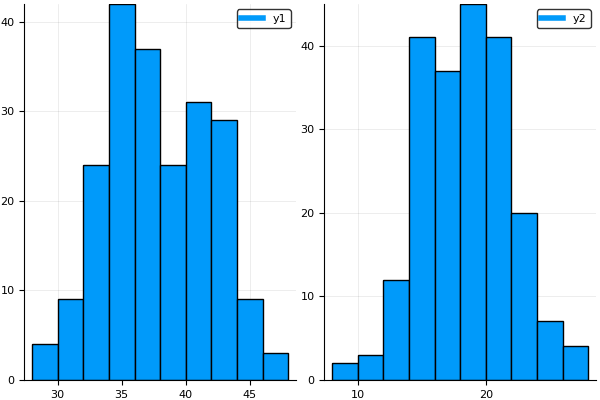

In [17]:
Y = convert(Matrix{Float64}, SNP_29C_trait[:, 4:end])
histogram(Y, layout = 2)

## Pre-processing data for heritability analysis

### Inverse-Normal Transformation

In this example, we consider a Rank-Based Inverse Normal Blom Transformations to remedy non-Normal Trait Values.

In [41]:
using Rmath

c = 3/8 # continuity correction c = 3/8
N = size(Y)[1]

Yt = zeros(Matrix{Float64}(size(Y)[1],size(Y)[2]))

tic()
for i in 1:size(Y)[2]
    for j in 1:size(Y)[1]
        value = (tiedrank(Y[:,i]) - c)/(N - 2c + 1)
        qz = qnorm.(value)
        Yt[j, i] = qz[j]
    end
end
toc() 

elapsed time: 0.06404246 seconds


0.06404246


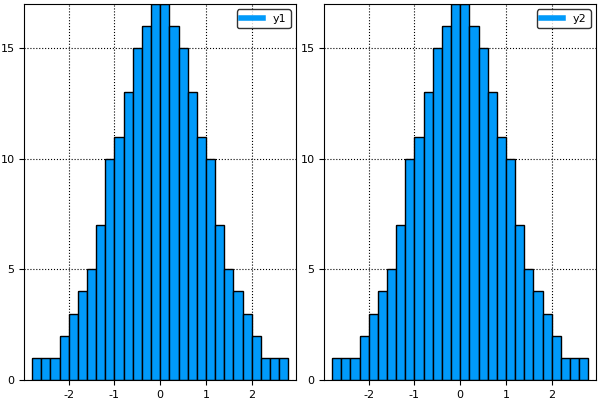

In [17]:
histogram(Yt, layout = 2 )

To prepare variance component model fitting, we form an instance of `VarianceComponentVariate`. The variance components are $(2\Phi, I)$.

In [23]:
using VarianceComponentModels
using VarianceComponentModels
sex = convert(Vector{Float64}, SNP_29C_trait[:, :SEX])
sex = sex - 1
X = [ones(length(sex)) sex]
# form data as VarianceComponentVariate
SNP_29Cdata_emp = VarianceComponentVariate(Y, X, (2ΦGRM, eye(length(Y))))
fieldnames(SNP_29Cdata_emp)


Use "VarianceComponentModel{T,M,BT,ΣT}(...) where {T,M,BT,ΣT}" instead.

Use "TwoVarCompModelRotate{T,BT}(...) where {T,BT}" instead.

Use "VarianceComponentVariate{T,M,YT,XT,VT}(...) where {T,M,YT,XT,VT}" instead.

Use "TwoVarCompVariateRotate{T,YT,XT}(...) where {T,YT,XT}" instead.


3-element Array{Symbol,1}:
 :Y
 :X
 :V

Before fitting the variance component model, we pre-compute the eigen-decomposition of $2\Phi_{\text{GRM}}$, the rotated responses, and the constant part in log-likelihood, and store them as a `TwoVarCompVariateRotate` instance, which is re-used in various variane component estimation procedures.

In [24]:
@time SNP_29Cdata_rotated_emp = TwoVarCompVariateRotate(SNP_29Cdata_emp);
fieldnames(SNP_29Cdata_rotated_emp)

  0.843530 seconds (407.42 k allocations: 21.374 MiB, 1.71% gc time)


5-element Array{Symbol,1}:
 :Yrot    
 :Xrot    
 :eigval  
 :eigvec  
 :logdetV2

## Heritability of Single Traits

### Heritability via Empirical Kinship Matrix with Sex as a Covariate

We use Fisher scoring algorithm to fit variance component model for each single trait.

In [30]:
using VarianceComponentModels
hST_emp = zeros(2)
# standard errors of estimated heritability
hST_se_emp = zeros(2)
# additive genetic effects
σ2a = zeros(2)
# enviromental effects
σ2e = zeros(2)

tic()
for j in 1:2
println(names(SNP_29C_trait)[j + 3])
traitj_data = TwoVarCompVariateRotate(SNP_29Cdata_rotated_emp.Yrot[:, j], SNP_29Cdata_rotated_emp.Xrot, SNP_29Cdata_rotated_emp.eigval, SNP_29Cdata_rotated_emp.eigvec, SNP_29Cdata_rotated_emp.logdetV2)
    # initialize model parameters
traitj_model = VarianceComponentModel(traitj_data)
    # estimate variance components
_, _, _, Σcov, _, _ = mle_fs!(traitj_model, traitj_data; solver=:Ipopt, verbose=false)
σ2a[j] = traitj_model.Σ[1][1]
σ2e[j] = traitj_model.Σ[2][1]
@show σ2a[j], σ2e[j]
h, hse = heritability(traitj_model.Σ, Σcov)
hST_emp[j] = h[1]
hST_se_emp[j] = hse[1]
end
toc()

Trait1
(σ2a[j], σ2e[j]) = (4.1558406725548895, 2.0745023385298738)
Trait2
(σ2a[j], σ2e[j]) = (4.462117090728428, 1.9981701701240648)
elapsed time: 2.855807793 seconds


2.855807793

In [31]:
Heritability_GRM_sex = [hST_emp'; hST_se_emp']

2×2 Array{Float64,2}:
 0.667032   0.690699 
 0.0761146  0.0699609

### Heritability via Theoretical Kinship Matrix with Sex as a Covariate

In [32]:
SNP_29Cdata_ped = VarianceComponentVariate(Y, X, (2ΦGRM_ped, eye(length(Y))))
SNP_29Cdata_rotated_ped = TwoVarCompVariateRotate(SNP_29Cdata_ped);

In [33]:
hST_peds = zeros(2)
# standard errors of estimated heritability
hST_se_peds = zeros(2)
# additive genetic effects
σ2a = zeros(2)
# enviromental effects
σ2e = zeros(2)

tic()
for j in 1:2
println(names(SNP_29C_trait)[j + 3])
traitj_data = TwoVarCompVariateRotate(SNP_29Cdata_rotated_ped.Yrot[:, j], SNP_29Cdata_rotated_ped.Xrot, SNP_29Cdata_rotated_ped.eigval, SNP_29Cdata_rotated_ped.eigvec, SNP_29Cdata_rotated_ped.logdetV2)
    # initialize model parameters
traitj_model = VarianceComponentModel(traitj_data)
    # estimate variance components
_, _, _, Σcov, _, _ = mle_fs!(traitj_model, traitj_data; solver=:Ipopt, verbose=false)
σ2a[j] = traitj_model.Σ[1][1]
σ2e[j] = traitj_model.Σ[2][1]
@show σ2a[j], σ2e[j]
h, hse = heritability(traitj_model.Σ, Σcov)
hST_peds[j] = h[1]
hST_se_peds[j] = hse[1]
end
toc()

Trait1
(σ2a[j], σ2e[j]) = (3.2750662710799565, 3.1569249886262725)
Trait2
(σ2a[j], σ2e[j]) = (3.008905077008311, 3.5727082358711293)
elapsed time: 0.211059102 seconds


0.211059102

In [34]:
Heritability_ped_sex = [hST_peds'; hST_se_peds']

2×2 Array{Float64,2}:
 0.509184  0.457168
 0.124119  0.137528

## Pairwise traits

Joint analysis of multiple traits is subject to intensive research recently. Following code snippet does joint analysis of all pairs of traits.

### Joint Analysis via Empirical Kinship Matrix

In [35]:
# additive genetic effects (2x2 psd matrices) from bavariate trait analysis;
Σa = Array{Matrix{Float64}}(2, 2)
# environmental effects (2x2 psd matrices) from bavariate trait analysis;
Σe = Array{Matrix{Float64}}(2, 2)

tic()
for i in 1:2
    for j in (i+1):2
        println(names(SNP_29C_trait)[i + 3], names(SNP_29C_trait)[j + 3])
        # form data set for (trait1, trait2)
        traitij_data = TwoVarCompVariateRotate(SNP_29Cdata_rotated_emp.Yrot[:, [i;j]], SNP_29Cdata_rotated_emp.Xrot, 
            SNP_29Cdata_rotated_emp.eigval, SNP_29Cdata_rotated_emp.eigvec, SNP_29Cdata_rotated_emp.logdetV2)
        # initialize model parameters
        traitij_model = VarianceComponentModel(traitij_data)
        # estimate variance components
        mle_fs!(traitij_model, traitij_data; solver=:Ipopt, verbose=true)
        Σa[i, j] = traitij_model.Σ[1]
        Σe[i, j] = traitij_model.Σ[2]
        @show Σa[i, j], Σe[i, j]
        @show traitij_model.B
    end
end
toc()

Trait1Trait2
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_

1.21899643

### Joint Analysis via Theoretical Kinship Matrix

In [36]:
# additive genetic effects (2x2 psd matrices) from bavariate trait analysis;
Σa_ped = Array{Matrix{Float64}}(2, 2)
# environmental effects (2x2 psd matrices) from bavariate trait analysis;
Σe_ped = Array{Matrix{Float64}}(2, 2)

tic()
for i in 1:2
    for j in (i+1):2
        println(names(SNP_29C_trait)[i + 3], names(SNP_29C_trait)[j + 3])
        # form data set for (trait1, trait2)
        traitij_data = TwoVarCompVariateRotate(SNP_29Cdata_rotated_ped.Yrot[:, [i;j]], SNP_29Cdata_rotated_ped.Xrot, 
            SNP_29Cdata_rotated_ped.eigval, SNP_29Cdata_rotated_ped.eigvec, SNP_29Cdata_rotated_ped.logdetV2)
        # initialize model parameters
        traitij_model = VarianceComponentModel(traitij_data)
        # estimate variance components
        mle_fs!(traitij_model, traitij_data; solver=:Ipopt, verbose=false)
        Σa_ped[i, j] = traitij_model.Σ[1]
        Σe_ped[i, j] = traitij_model.Σ[2]
        @show Σa_ped[i, j], Σe_ped[i, j]
    end
end
toc()

Trait1Trait2
(Σa_ped[i, j], Σe_ped[i, j]) = ([3.29155 0.868436; 0.868436 3.04316], [3.14546 0.427296; 0.427296 3.54909])
elapsed time: 0.192791778 seconds


0.192791778

## N-joint traits analysis

In some situations, such as studying the genetic covariance, we need to jointly analyze all N > 2 traits. 
We first try the **Fisher scoring algorithm**. (Demo: If SNP_29C dataset had N > 2 traits.)

### Joint Analysis via Empirical Kinship Matrix

In [37]:
# initialize model parameters
traitall_model_emp = VarianceComponentModel(SNP_29Cdata_rotated_emp)
# estimate variance components using Fisher scoring algorithm
@time mle_fs!(traitall_model_emp, SNP_29Cdata_rotated_emp; solver=:Ipopt, verbose=true)

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

(-950.3078799502623, VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}([40.893 20.4858; -6.62851 -4.40122], ([4.126 1.236; 1.236 4.43915], [2.09245 -0.0355116; -0.0355116 2.01215]), Array{Float64}(0,4), Char[], Float64[], -Inf, Inf), ([0.965563 0.984083; 0.984083 1.00285], [0.562486 0.563763; 0.563763 0.564966]), [0.932311 0.1833 … -0.056442 -0.00782437; 0.1833 0.968419 … -0.00782437 -0.0574465; … ; -0.056442 -0.00782437 … 0.317829 0.0321524; -0.00782437 -0.0574465 … 0.0321524 0.319187], [0.186128 0.194696; 0.319451 0.336197], [0.0346436 -0.0466923 0.0121335 -0.0180862; -0.0466923 0.102049 -0.0180862 0.0395286; 0.0121335 -0.0180862 0.0379067 -0.0517159; -0.0180862 0.0395286 -0.0517159 0.113029])

From the output we can see the Fisher scoring algorithm converged after ~30 iterations. Let's try the **MM algorithm**.

In [38]:
# reset model parameters
traitall_model_emp = VarianceComponentModel(SNP_29Cdata_rotated_emp)
# estimate variance components using Fisher scoring algorithm
@time mle_mm!(traitall_model_emp, SNP_29Cdata_rotated_emp; verbose=true)


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -1.901925e+05
       1  -1.114684e+03
       2  -1.014803e+03
       3  -9.803274e+02
       4  -9.688978e+02
       5  -9.645507e+02
       6  -9.622363e+02
       7  -9.605340e+02
       8  -9.590777e+02
       9  -9.577832e+02
      10  -9.566347e+02
      20  -9.512965e+02
      30  -9.504622e+02
      40  -9.503336e+02
      50  -9.503123e+02
      60  -9.503087e+02
      70  -9.503080e+02

  0.523347 seconds (247.33 k allocations: 12.507 MiB)


(-950.3079289938598, VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}([40.8929 20.4857; -6.6283 -4.40116], ([4.11795 1.23231; 1.23231 4.43644], [2.0972 -0.0334839; -0.0334839 2.01363]), Array{Float64}(0,4), Char[], Float64[], -Inf, Inf), ([0.96503 0.98374; 0.98374 1.00269], [0.562887 0.564037; 0.564037 0.565109]), [0.931283 0.18302 … -0.056492 -0.00784266; 0.18302 0.967744 … -0.00784266 -0.057492; … ; -0.056492 -0.00784266 … 0.318138 0.0322739; -0.00784266 -0.057492 … 0.0322739 0.319348], [0.186079 0.194854; 0.319264 0.336419], [0.0346255 -0.0466375 0.0121489 -0.018098; -0.0466375 0.101929 -0.018098 0.0395544; 0.0121489 -0.018098 0.0379679 -0.0517843; -0.018098 0.0395544 -0.0517843 0.113178])

It converges after ~70 iterations.

### Joint Analysis via Theoretical Kinship Matrix

In [39]:
# initialize model parameters
traitall_model_ped = VarianceComponentModel(SNP_29Cdata_rotated_ped)
# estimate variance components using Fisher scoring algorithm
@time mle_fs!(traitall_model_ped, SNP_29Cdata_rotated_ped; solver=:Ipopt, verbose=true)

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

(-975.9718042997582, VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}([40.8046 20.2384; -6.31975 -4.36967], ([3.29155 0.868436; 0.868436 3.04316], [3.14546 0.427296; 0.427296 3.54909]), Array{Float64}(0,4), Char[], Float64[], -Inf, Inf), ([1.01209 1.01438; 1.01438 1.01625], [0.732787 0.754108; 0.754108 0.775871]), [1.02433 0.218799 … -0.107296 -0.0211344; 0.218799 1.02896 … -0.0211344 -0.110622; … ; -0.107296 -0.0211344 … 0.568679 0.102172; -0.0211344 -0.110622 … 0.102172 0.601976], [0.294843 0.248448; 0.354237 0.327564], [0.0869326 -0.056033 0.0346471 -0.0167951; -0.056033 0.125484 -0.0167951 0.0385817; 0.0346471 -0.0167951 0.0617266 -0.048602; -0.0167951 0.0385817 -0.048602 0.107298])

From the output we can see the Fisher scoring algorithm converged after ~35 iterations. Let's try the **MM algorithm**.

In [40]:
# reset model parameters
traitall_model_ped = VarianceComponentModel(SNP_29Cdata_rotated_ped)
# estimate variance components using Fisher scoring algorithm
@time mle_mm!(traitall_model_ped, SNP_29Cdata_rotated_ped; verbose=true)


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -4.886585e+04
       1  -1.086822e+03
       2  -1.009878e+03
       3  -9.856915e+02
       4  -9.787536e+02
       5  -9.768659e+02
       6  -9.763558e+02
       7  -9.762082e+02
       8  -9.761556e+02
       9  -9.761287e+02
      10  -9.761099e+02
      20  -9.760162e+02
      30  -9.759866e+02
      40  -9.759768e+02
      50  -9.759735e+02
      60  -9.759724e+02
      70  -9.759720e+02

  0.210188 seconds (29.79 k allocations: 2.321 MiB, 6.45% gc time)


(-975.971885281387, VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}([40.8044 20.2382; -6.31953 -4.36959], ([3.30612 0.873603; 0.873603 3.04595], [3.1354 0.4238; 0.4238 3.54718]), Array{Float64}(0,4), Char[], Float64[], -Inf, Inf), ([1.01345 1.0152; 1.0152 1.01651], [0.732282 0.753807; 0.753807 0.775775]), [1.02709 0.219542 … -0.107393 -0.021154; 0.219542 1.03064 … -0.021154 -0.110695; … ; -0.107393 -0.021154 … 0.568225 0.102017; -0.021154 -0.110695 … 0.102017 0.601827], [0.295078 0.248066; 0.354281 0.327321], [0.0870707 -0.0560476 0.0344887 -0.0167139; -0.0560476 0.125515 -0.0167139 0.0383889; 0.0344887 -0.0167139 0.0615366 -0.0485389; -0.0167139 0.0383889 -0.0485389 0.107139])

It converges after ~70 iterations.

## Save analysis results

In [ ]:
using JLD
@save "SNP_29C_results.jld"
whos()